In [1]:
import torch as tr
from torch import nn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [2]:
# Create known parameters
weight = 0.7
bias = 0.3

# Create
start = 0
end = 1
step = 0.02
X = tr.arange(start, end, step).unsqueeze(dim=1)
y = weight * X + bias

X[:10], y[:10], len(X), len(y)

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]),
 50,
 50)

## Create train/test split

In [3]:
train_split = int(0.8 * len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train), len(X_test), len(y_train), len(y_test)

(40, 10, 40, 10)

In [4]:
def plot_predictions(train_data=X_train,
                     train_labels=y_train,
                     test_data=X_test,
                     test_labels=y_test,
                     predictions=None):
    plt.figure(figsize=(10,7))

    plt.scatter(train_data, train_labels, c='b', label='Training data')
    plt.scatter(test_data, test_labels, c='g', s=4, label='Testing data')

    if predictions is not None:
        plt.scatter(test_data, predictions, c='r', label='Predictions')
    plt.legend(prop={'size':14});  

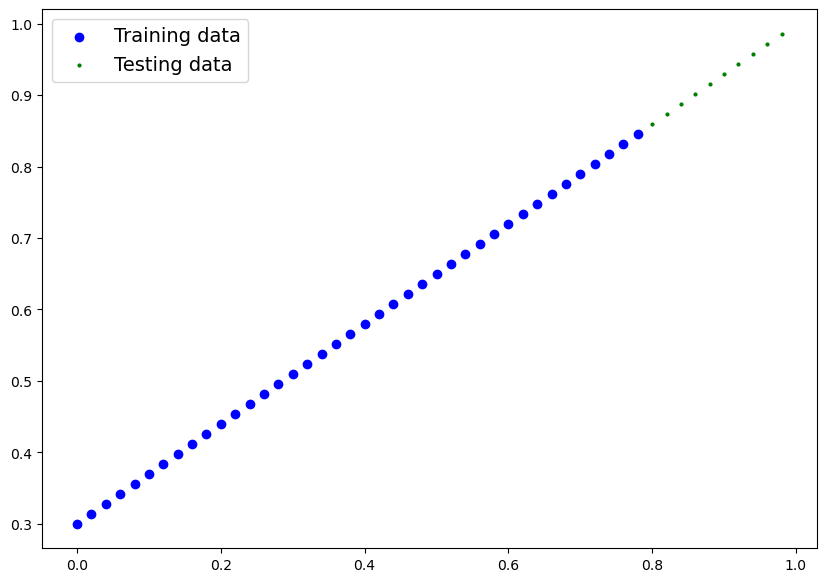

In [5]:
plot_predictions();

## Building a model

In [6]:
# Create linear regression model class
class LinearRegressionModel(nn.Module): # Almost everything in Pytorch inherits from nn.Module
    def __init__(self):
        super().__init__()
        self.weights = nn.Parameter(tr.randn(1, requires_grad=True, dtype=tr.float))
        self.bias = nn.Parameter(tr.randn(1, requires_grad=True, dtype=tr.float))
    # Forward method to define the computation in the model
    def forward(self, x: tr.Tensor) -> tr.Tensor:
        return self.weights * x + self.bias

## Checking the contents of our Pytorch model

In [7]:
# Create a random seed
tr.manual_seed(42)

# Create an instance of the model 
model_0 = LinearRegressionModel()

# Check out the parameters
list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [8]:
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

In [9]:
weight, bias

(0.7, 0.3)

### Making predictions using `torch.inference_mode()`

In [10]:
# Make predictions with our model
with tr.inference_mode():
    y_preds = model_0(X_test)

y_preds

tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]])

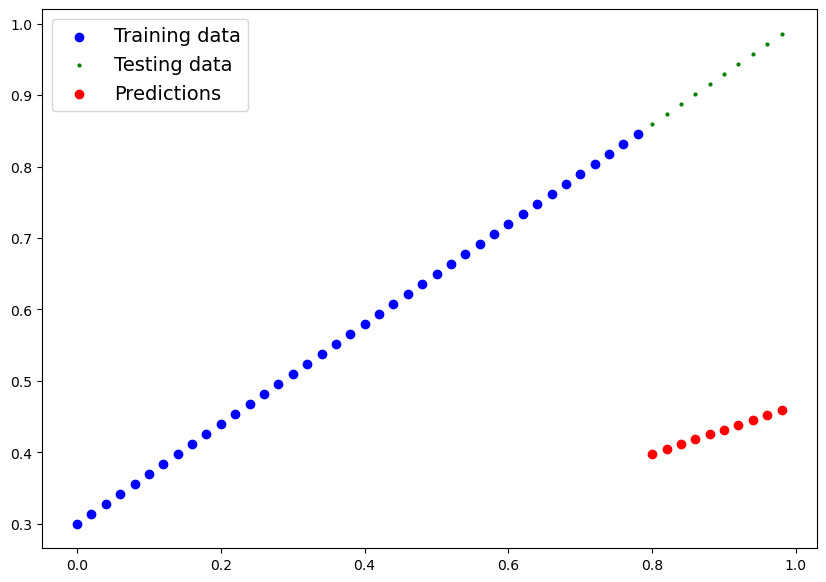

In [11]:
plot_predictions(predictions=y_preds)

In [12]:
# Setup a loss function
loss_fn = nn.L1Loss()

# Setup an optimizer 
optimizer = tr.optim.SGD(params=model_0.parameters(),
                        lr=0.01) # lr = learning rate = most important  hyperparameter

## Building a training loop and testing loop

In [20]:
epochs = 100
epoch_count = []
loss_values = []
test_loss_values = []


# 0. loop through the data
for epoch in range(epochs):
    # Set the model to training mode
    model_0.train() # train mode in PyTorch sets all parameters that require gradients to reqire gradiends

    # 1. Forward pass
    y_pred = model_0(X_train)

    # 2. Calculate the loss
    loss = loss_fn(y_pred, y_train)

    # 3. Optimzer zero grad
    optimizer.zero_grad()

    # 4. Perform backpropagation on the loss with respect to the parameters of the model
    loss.backward() # by default how the optimizer changes will acculmulate through the lop so... we have to zero them above in step 3 for next iteration in the loop

    # 5. Step the optimizer (perform gradient descent)
    optimizer.step()
    
    # Testing
    model_0.eval() # Turns off gradient tracking
    with tr.inference_mode():
        # 1. do the forward pass
        test_pred = model_0(X_test)

        # 2. Calculate the loss
        test_loss = loss_fn(test_pred, y_test)
        
    # Print out what's happening
    if epoch % 20 == 0:
        epoch_count.append(epoch)
        loss_values.append(loss)
        test_loss_values.append(test_loss)
        print(f'Epoch: {epoch} | Loss: {loss} | Test loss: {test_loss}')

    # Print our model state_dict()
    if epoch % 99 == 0:
        print(model_0.state_dict())

Epoch: 0 | Loss: 0.024458957836031914 | Test loss: 0.05646304413676262
OrderedDict([('weights', tensor([0.5800])), ('bias', tensor([0.3503]))])
Epoch: 20 | Loss: 0.01758546568453312 | Test loss: 0.04060482233762741
Epoch: 40 | Loss: 0.010716589167714119 | Test loss: 0.024059748277068138
Epoch: 60 | Loss: 0.0038517764769494534 | Test loss: 0.008201557211577892
Epoch: 80 | Loss: 0.008932482451200485 | Test loss: 0.005023092031478882
OrderedDict([('weights', tensor([0.6990])), ('bias', tensor([0.3093]))])


In [14]:
with tr.inference_mode():
    y_preds_new = model_0(X_test)

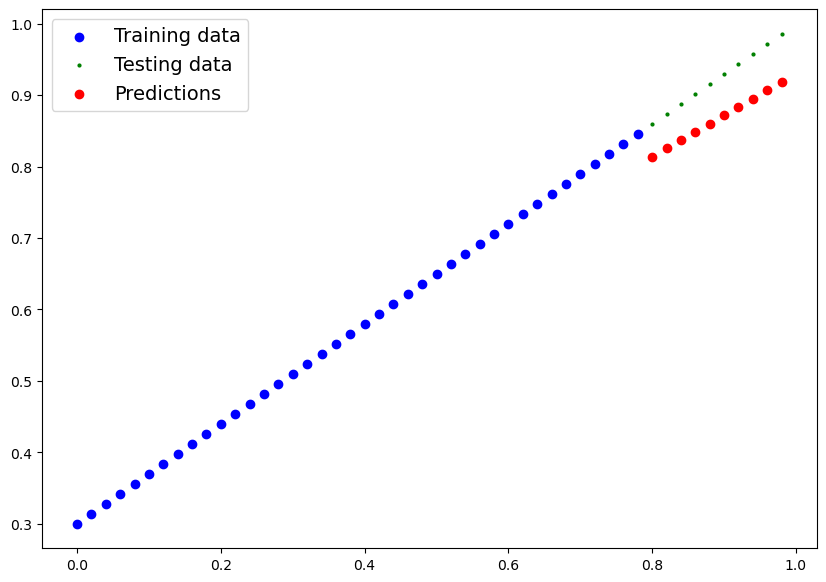

In [15]:
plot_predictions(predictions=y_preds_new)

In [21]:
with tr.inference_mode():
    y_preds_improved = model_0(X_test)

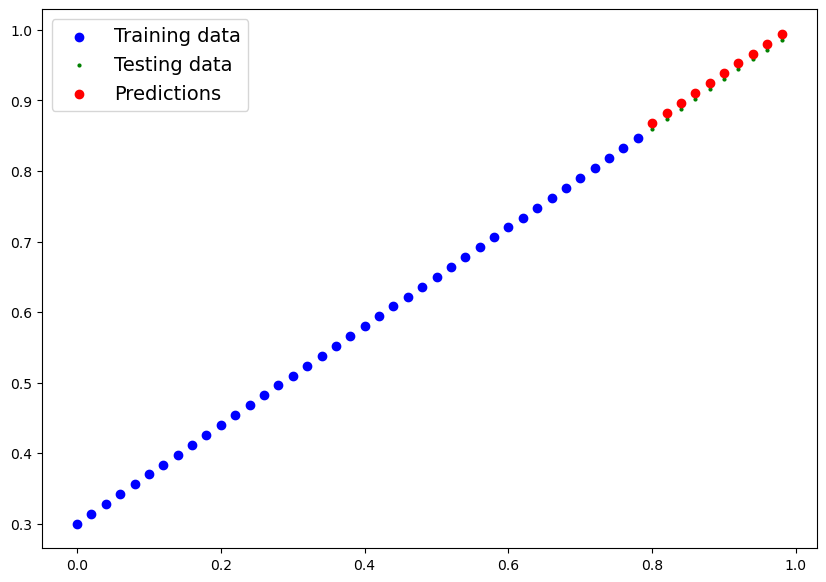

In [22]:
plot_predictions(predictions=y_preds_improved) # plot predictions after 100 iterations

In [23]:
np.array(tr.tensor(loss_values)), test_loss_values

(array([0.02445896, 0.01758547, 0.01071659, 0.00385178, 0.00893248],
       dtype=float32),
 [tensor(0.0565),
  tensor(0.0406),
  tensor(0.0241),
  tensor(0.0082),
  tensor(0.0050)])

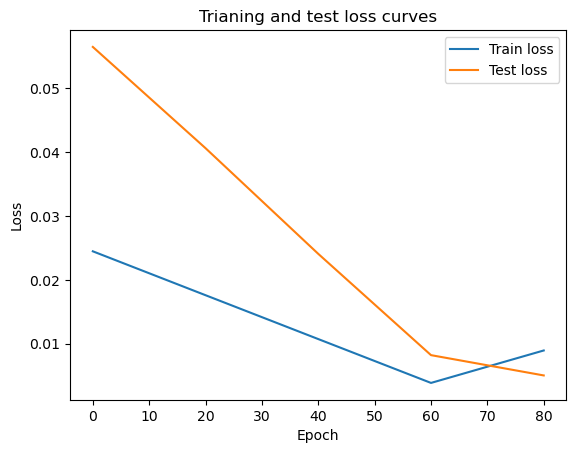

In [24]:
# Plot the loss curves
plt.plot(epoch_count, np.array(tr.tensor(loss_values).numpy()), label='Train loss')
plt.plot(epoch_count, test_loss_values, label='Test loss')
plt.title('Trianing and test loss curves')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend();

## Saving a model in PyTorch

In [25]:
# Saving our PyTorch model
from pathlib import Path

# Create models directory
MODEL_PATH = Path('models')
MODEL_PATH.mkdir(parents=True, exist_ok=True)

MODEL_NAME = 'pytorch_model_workflow.pth'
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

MODEL_SAVE_PATH
# Save the model state dict
print(f'Saving model to: {MODEL_SAVE_PATH}')
tr.save(obj=model_0.state_dict(),
        f=MODEL_SAVE_PATH)

Saving model to: models\pytorch_model_workflow.pth


## Loading a PyTorch model

In [28]:
model_0.state_dict()

OrderedDict([('weights', tensor([0.6990])), ('bias', tensor([0.3093]))])

In [29]:
loaded_model_0 = LinearRegressionModel()

# Load the saved state_dict of model_0
loaded_model_0.load_state_dict(tr.load(f=MODEL_SAVE_PATH))

<All keys matched successfully>

In [30]:
loaded_model_0.state_dict()

OrderedDict([('weights', tensor([0.6990])), ('bias', tensor([0.3093]))])

In [31]:
loaded_model_0.eval()
with tr.inference_mode():
    loaded_model_preds = loaded_model_0(X_test)

loaded_model_preds

tensor([[0.8685],
        [0.8825],
        [0.8965],
        [0.9105],
        [0.9245],
        [0.9384],
        [0.9524],
        [0.9664],
        [0.9804],
        [0.9944]])